# NWFZ Population over time

## Sources

- Population Data (Total Population on 01 July): United Nations, Department of Economic and Social Affairs, Population Division (2022). World Population Prospects 2022, Online Edition. Retrieved from [population.un.org/wpp/Download/Standard/CSV/](https://population.un.org/wpp/Download/Standard/CSV/)
- Existing paper for sanity checks: [www.researchgate.net/figure/The-fraction-of-the-worlds-current-population-that-lives-in-Nuclear-Weapon-Free-Zones_fig3_317109016](https://www.researchgate.net/figure/The-fraction-of-the-worlds-current-population-that-lives-in-Nuclear-Weapon-Free-Zones_fig3_317109016)


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
population_raw = pd.read_csv("./tmp/WPP2022_TotalPopulationBySex.csv")
nwfz_states = pd.read_csv("./data/nwfz_states.csv")

/var/folders/7l/mfh_67fs1_j6zj997d0xy1cr0000gn/T/ipykernel_74181/460315171.py:4: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  population_raw = pd.read_csv("./tmp/WPP2022_TotalPopulationBySex.csv")


In [10]:
nwfz_states.in_force = nwfz_states.in_force.astype(int, copy=False)

pops = population_raw.loc[
	(population_raw["Variant"] == "Medium") &
	(population_raw["LocTypeName"] == "Country/Area")
	& (population_raw["ISO3_code"])
	# & (population_raw["Time"] <= 2024)
].copy()

def set_is_nwfz(row):
	if row.ISO3_code in list(nwfz_states["iso3"]):
		if row.Time > nwfz_states.loc[nwfz_states["iso3"] == row.ISO3_code, 'in_force'].values[0]:
			return True
		return False
	else:
		return False

def set_adjPop(row):
	if row.is_nwfz == True:
		return row.PopTotal
	else:
		return 0
	
pops["is_nwfz"] = pops.apply(set_is_nwfz, axis=1)
pops["adjPop"] = pops.apply(set_adjPop, axis=1)

pops = pops.pivot(
	index=["Time"],
	columns=["Location"],
	values=["PopTotal", "adjPop"]
)

pops["total"] = pops["PopTotal"].sum(axis=1)
pops["nwfz_total"] = pops["adjPop"].sum(axis=1)
pops["ratio"]= pops["nwfz_total"].divide(pops["total"])

          Time         total    nwfz_total     ratio
Location                                            
0         1950  2.499322e+09  0.000000e+00  0.000000
1         1951  2.543130e+09  0.000000e+00  0.000000
2         1952  2.590271e+09  0.000000e+00  0.000000
3         1953  2.640279e+09  0.000000e+00  0.000000
4         1954  2.691979e+09  0.000000e+00  0.000000
..         ...           ...           ...       ...
146       2096  1.038852e+10  5.446405e+09  0.524272
147       2097  1.037989e+10  5.457582e+09  0.525784
148       2098  1.037045e+10  5.468063e+09  0.527274
149       2099  1.036027e+10  5.477890e+09  0.528740
150       2100  1.034932e+10  5.487033e+09  0.530183

[151 rows x 4 columns]


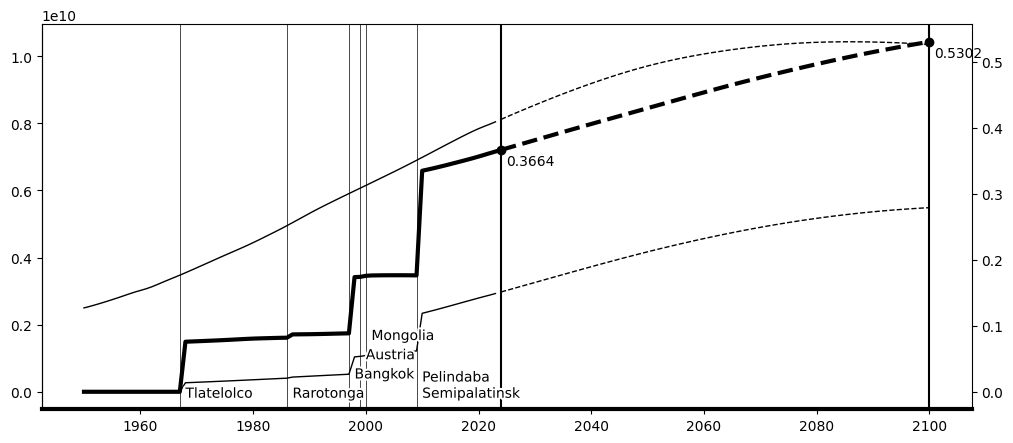

In [83]:
# Plot
t = pops.loc[:, ["total", 'nwfz_total', 'ratio']].reset_index()

t.loc[:, ["total", "nwfz_total"]] = t[["total", "nwfz_total"]].multiply(1e3)

print(t)

labels = pd.DataFrame([
	{"year": 1967, "text": "Tlatelolco", "yo": 0},
	{"year": 1986, "text": "Rarotonga", "yo": 0},
	{"year": 1997, "text": "Bangkok", "yo": .05},
	{"year": 1999, "text": "Austria", "yo": .1},
	{"year": 2000, "text": "Mongolia", "yo": .15},
	{"year": 2009, "text": "Pelindaba\nSemipalatinsk", "yo": 0},
])

fig, ax = plt.subplots(figsize=(12,5))
ax.spines[['top','right']].set_visible(False)
ax.spines['bottom'].set_linewidth(3)


plt.plot(t[:74]["Time"], t[:74][["total", "nwfz_total"]], color="black",lw=1, zorder=0)
plt.plot(t[74:]["Time"], t[74:][["total", "nwfz_total"]], color="black",lw=1, linestyle="dashed")

ax2 = ax.twinx()
ax2.plot(t[:75]["Time"], t[:75]["ratio"], color="black", lw=3, zorder=100, marker="o", markevery=[74])
ax2.plot(t[74:]["Time"], t[74:]["ratio"], color="black", lw=3, linestyle='dashed', marker="o", markevery=[-1])

for index, l in labels.iterrows():
	ax.axvline(x=l["year"], color="black", lw=.5, zorder=-10)
	ax.annotate(
		text=l["text"],
		xy=(l["year"], t.loc[t["Time"] == l["year"]].ratio.values[0]),
		xytext=(l["year"] + 1,.03 + l["yo"]),
		textcoords=("data","axes fraction"),
		path_effects=[pe.withStroke(linewidth=3, foreground="white")],
		zorder=200
		)

ratios_marked = [2024, 2100]

for index, year in enumerate(ratios_marked):
	ax.axvline(x=year, color="black", zorder=-10, lw=1.5)
	ratio_today = t.loc[t["Time"] == year].ratio.values[0]
	ax2.annotate(
		text=round(ratio_today, 4),
		xy=(year, ratio_today),
		xytext=(5,-15),
		textcoords=("offset pixels","offset pixels"),
		zorder=200
	)